### step1. MySQL에서 mmp 테이블 불러오기

In [1]:
import pandas as pd
from sqlalchemy import create_engine

# MySQL 연결 정보 설정
user = 'root'
password = '9703'
host = 'localhost'  
port = 3306
database = 'performance_marketing'

# SQLAlchemy 엔진 생성
engine_mmp = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}')

# SQL 쿼리 작성 (2023년 10월 ~ 12월)
query_mmp = """
SELECT *
FROM mmp
WHERE date >= '2023-10-01' AND date <= '2023-12-31';
"""

# 쿼리 실행 및 데이터프레임으로 불러오기
df_mmp_q4_2023 = pd.read_sql(query_mmp, engine_mmp)

In [2]:
# mmp 테이블과 조인을 위해 performace table 불러오기
# SQLAlchemy 엔진 생성
engine_pm = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}')

# SQL 쿼리 작성 (2023년 10월 ~ 12월)
query_pm = """
SELECT *
FROM performance
WHERE date >= '2023-10-01' AND date <= '2023-12-31';
"""

# 쿼리 실행 및 데이터프레임으로 불러오기
df_pm_q4_2023 = pd.read_sql(query_pm, engine_pm)

### step2. 광고 채널별 성과 측정

In [3]:
# 집계할 컬럼 리스트
mmp_metrics = ['clicks', 'conversion_sales', 'conversions', 'signup', 'install']

# groupby 후 sum
df_mmp_channel = df_mmp_q4_2023.groupby('channel')[mmp_metrics].sum().reset_index()

In [4]:
# 결과 확인
df_mmp_channel

,channel,clicks,conversion_sales,conversions,signup,install
0,google,737957.91,4.069810e+09,35185.0,10670.0,17712.0
1,kakao,733856.00,4.080860e+09,34358.0,10548.0,17658.0
2,meta,694144.35,4.639629e+09,32951.0,10248.0,16932.0
3,naver,744389.90,6.092334e+09,33932.0,10566.0,17503.0
4,naver_search,706192.37,5.963532e+09,34225.0,10329.0,17313.0
5,youtube,738280.90,3.995476e+09,34191.0,10448.0,17432.0


In [5]:
# 집계할 컬럼 리스트
pm_metrics = ['impressions', 'clicks', 'spends', 'conversion_sales', 'conversions', 'signup']

# groupby 후 sum
df_pm_channel = df_pm_q4_2023.groupby('channel')[pm_metrics].sum().reset_index()

In [6]:
df_pm_channel

,channel,impressions,clicks,spends,conversion_sales,conversions,signup
0,google,23888965.0,1172001.0,561951452.0,4.839756e+09,41736.0,12698.0
1,kakao,24109223.0,1155423.0,545145507.0,4.797686e+09,40564.0,12425.0
2,meta,23152017.0,1092638.0,438815416.5,5.480643e+09,38740.0,12091.0
3,naver,24223434.0,1171003.0,369635618.4,7.271221e+09,40296.0,12504.0
4,naver_search,23955374.0,1133645.0,365693642.8,7.204791e+09,41065.0,12490.0
5,youtube,24250243.0,1181823.0,564788418.0,4.832036e+09,41605.0,12539.0


In [7]:
# mmp 테이블에는 'impressions', 'spends' 집계되지 않으므로 pm테이블과 조인을 진행
# 필요한 컬럼만 선택
df_pm_subset = df_pm_channel[['channel', 'impressions', 'spends']]

# channel을 기준으로 조인 (inner join)
df_channel_summary = df_mmp_channel.merge(df_pm_subset, on='channel', how='inner')

In [8]:
df_channel_summary

,channel,clicks,conversion_sales,conversions,signup,install,impressions,spends
0,google,737957.91,4.069810e+09,35185.0,10670.0,17712.0,23888965.0,561951452.0
1,kakao,733856.00,4.080860e+09,34358.0,10548.0,17658.0,24109223.0,545145507.0
2,meta,694144.35,4.639629e+09,32951.0,10248.0,16932.0,23152017.0,438815416.5
3,naver,744389.90,6.092334e+09,33932.0,10566.0,17503.0,24223434.0,369635618.4
4,naver_search,706192.37,5.963532e+09,34225.0,10329.0,17313.0,23955374.0,365693642.8
5,youtube,738280.90,3.995476e+09,34191.0,10448.0,17432.0,24250243.0,564788418.0


In [9]:
# 광고 성과 지표를 활용하여 파생컬럼 생성
import numpy as np

# CPC (Cost Per Click)
df_channel_summary["CPC"] = np.where(
    df_channel_summary["clicks"] != 0,
    df_channel_summary["spends"] / df_channel_summary["clicks"],
    0
)

# CTR (Click Through Rate)
df_channel_summary["CTR"] = np.where(
    df_channel_summary["impressions"] != 0,
    (df_channel_summary["clicks"] / df_channel_summary["impressions"]) * 100,
    0
)

# CVR (Conversion Rate)
df_channel_summary["CVR"] = np.where(
    df_channel_summary["clicks"] != 0,
    (df_channel_summary["conversions"] / df_channel_summary["clicks"]) * 100,
    0
)

# ROAS (Return On Ad Spend)
df_channel_summary["ROAS"] = np.where(
    df_channel_summary["spends"] != 0,
    (df_channel_summary["conversion_sales"] / df_channel_summary["spends"]) * 100,
    0
)

In [10]:
# 소수점 2자리까지 출력 
pd.set_option('display.float_format', '{:,.2f}'.format)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import matplotlib.font_manager as fm

# ✅ 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')  # Windows: 맑은 고딕
elif platform.system() == 'Darwin':  # macOS
    plt.rc('font', family='AppleGothic')
else:  # Linux (예: Google Colab, Ubuntu)
    # 나눔고딕 등 설치된 폰트 경로 지정
    fm_font = fm.FontProperties(fname='/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
    plt.rc('font', family=fm_font.get_name())

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16104\4212815169.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


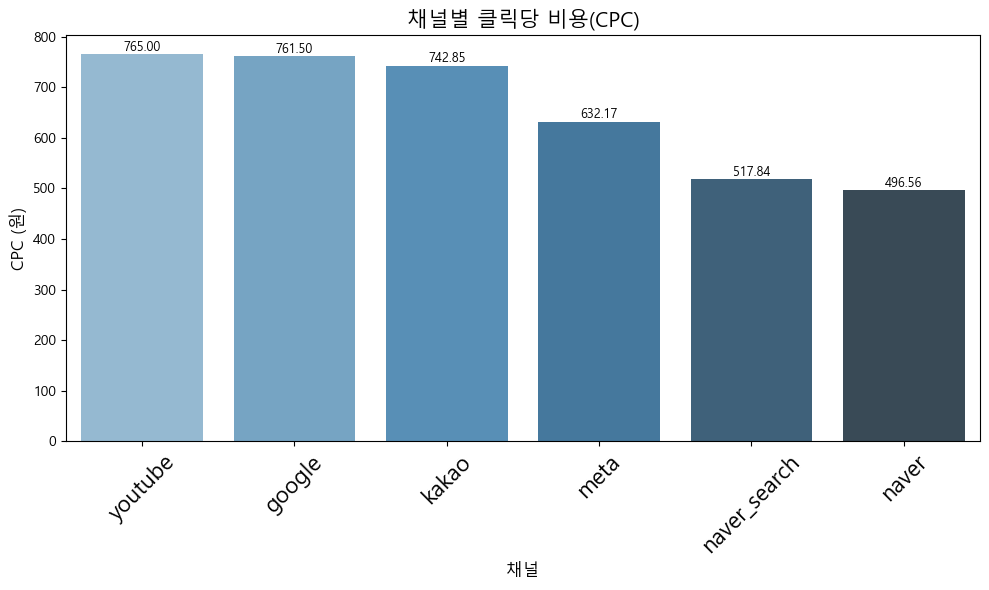

In [12]:
# ✅ 시각화 (CPC + 막대 위 값 표시)
plt.figure(figsize=(10, 6))
sorted_df = df_channel_summary.sort_values('CPC', ascending=False).reset_index(drop=True)

sns.barplot(
    x='channel',
    y='CPC',
    data=sorted_df,
    palette='Blues_d'
)
plt.title('채널별 클릭당 비용(CPC)', fontsize=15)
plt.xlabel('채널', fontsize=12)
plt.ylabel('CPC (원)', fontsize=12)
plt.xticks(rotation=45)

# ✅ x축 채널 이름의 폰트 크기 키우기
plt.xticks(rotation=45, fontsize=16)  # 폰트 크기 조정

# 막대 위에 값 표시
for index, row in sorted_df.iterrows():
    plt.text(index, row['CPC'] + 0.1, f"{row['CPC']:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16104\2153828308.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


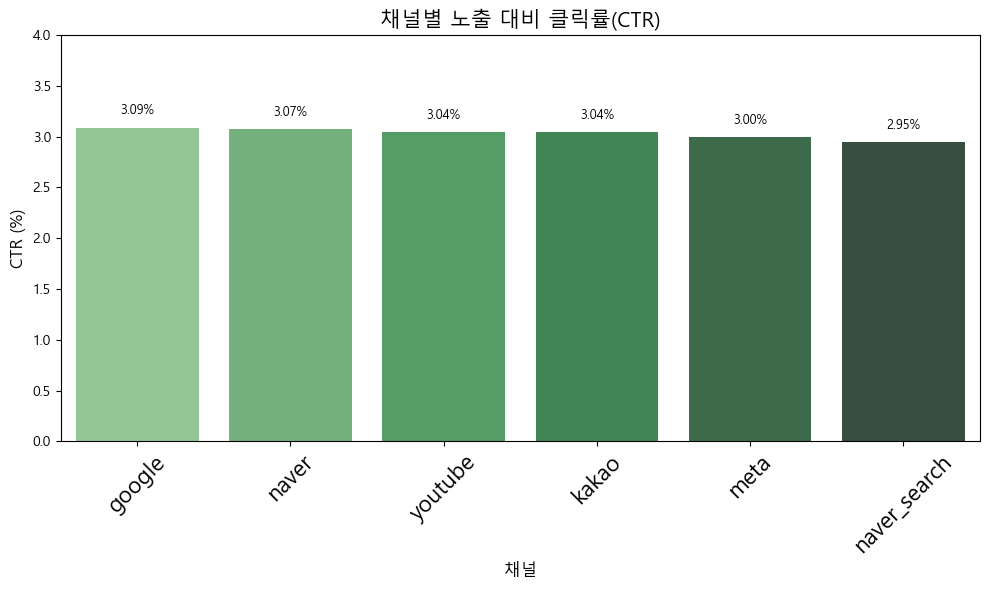

In [16]:
# ✅ 채널별 CTR 시각화 (y축 범위 3~7%)
plt.figure(figsize=(10, 6))
sns.barplot(
    x='channel',
    y='CTR',
    data=df_channel_summary.sort_values('CTR', ascending=False),
    palette='Greens_d'
)

plt.title('채널별 노출 대비 클릭률(CTR)', fontsize=15)
plt.xlabel('채널', fontsize=12)
plt.ylabel('CTR (%)', fontsize=12)
plt.xticks(rotation=45)

# ✅ x축 채널 이름의 폰트 크기 키우기
plt.xticks(rotation=45, fontsize=16)  # 폰트 크기 조정

# y축 범위 설정
plt.ylim(0, 4)

# 막대 위에 정확한 값 표시
for index, row in df_channel_summary.sort_values('CTR', ascending=False).reset_index().iterrows():
    plt.text(index, row['CTR'] + 0.1, f"{row['CTR']:.2f}%", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16104\3918286484.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


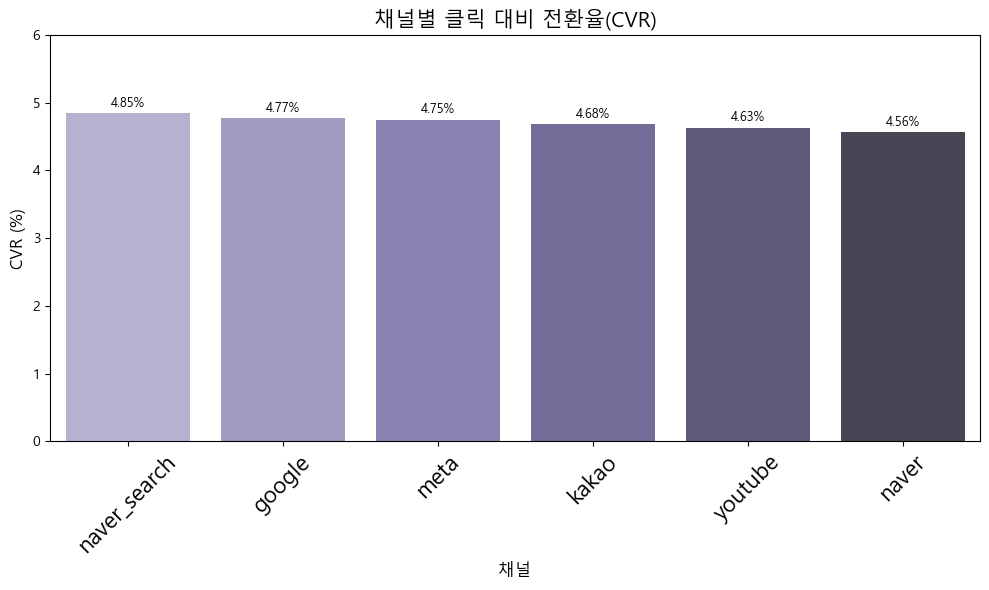

In [18]:
# ✅ 시각화 (CVR + 막대 위 값 표시)
plt.figure(figsize=(10, 6))
sorted_df = df_channel_summary.sort_values('CVR', ascending=False).reset_index(drop=True)

sns.barplot(
    x='channel',
    y='CVR',
    data=sorted_df,
    palette='Purples_d'
)
plt.title('채널별 클릭 대비 전환율(CVR)', fontsize=15)
plt.xlabel('채널', fontsize=12)
plt.ylabel('CVR (%)', fontsize=12)
plt.xticks(rotation=45)

# ✅ x축 채널 이름의 폰트 크기 키우기
plt.xticks(rotation=45, fontsize=16)  # 폰트 크기 조정

# ✅ y축 범위 설정
plt.ylim(0, 6)

# ✅ 막대 위에 값 표시
for index, row in sorted_df.iterrows():
    plt.text(index, row['CVR'] + 0.05, f"{row['CVR']:.2f}%", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16104\1713759849.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


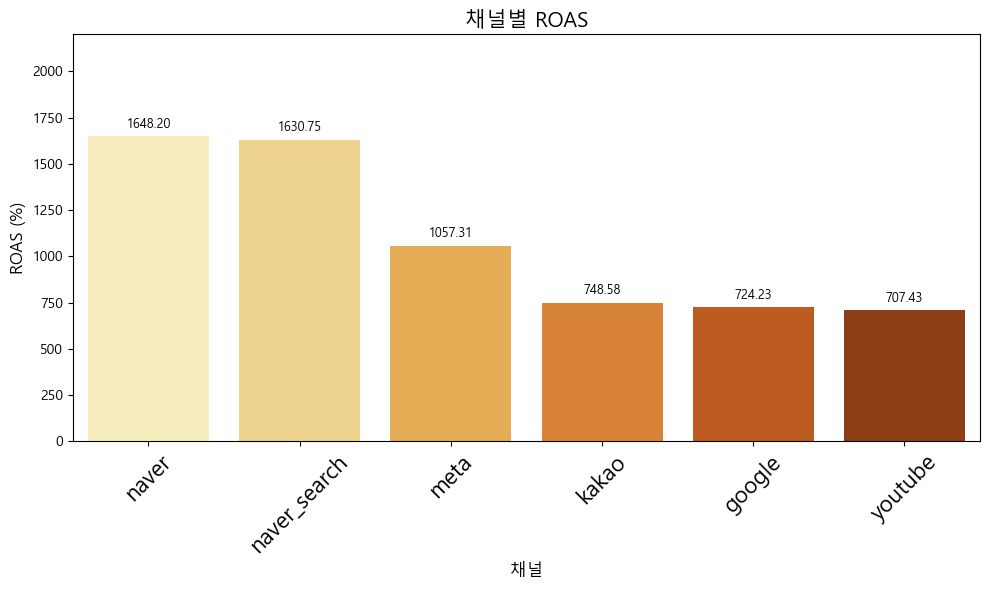

In [17]:
# ✅ 채널별 ROAS 막대그래프
plt.figure(figsize=(10, 6))
sorted_df = df_channel_summary.sort_values('ROAS', ascending=False).reset_index(drop=True)

sns.barplot(
    x='channel',
    y='ROAS',
    data=sorted_df,
    palette='YlOrBr'  # 노란색 계열 팔레트
)
plt.title('채널별 ROAS', fontsize=15)
plt.xlabel('채널', fontsize=12)
plt.ylabel('ROAS (%)', fontsize=12)
plt.xticks(rotation=45)

# ✅ x축 채널 이름의 폰트 크기 키우기
plt.xticks(rotation=45, fontsize=16)  # 폰트 크기 조정

# ✅ y축 범위 설정
plt.ylim(0, 2200)

# ✅ 막대 위에 ROAS 값 표기 (소수 둘째 자리까지)
for index, row in sorted_df.iterrows():
    plt.text(index, row['ROAS'] + 30, f"{row['ROAS']:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()